In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,classification_report
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import librosa
import soundfile
import os, glob, pickle
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [38]:
#Extract features (mfcc, chroma, mel) from a sound file
#if chroma do short time fourier transform
#hstack() stacks arrays in sequence horizontally (in a columnar fashion)
#chroma-pertains to 12 pitch class,hstack() stacks arrays in sequence horizontally (in a columnar fashion),
#mel: Mel Spectrogram Frequency
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        sample_rate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:#frequency domain feature
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [39]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#DataFlair - Emotions to observe
observed_emotions=['neutral', 'calm', 'happy', 'fearful', 'surprised', 'angry']

In [40]:
#DataFlair - Load the data and extract features for each sound file
def load_data():
    x,y=[],[]
    for file in glob.glob("C:\\Users\COMPUTER\Desktop\Speech_Recognition_dataset\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        if emotion=='calm':
           emotion='not_confident'
        elif emotion=='fearful':
           emotion='not_confident'
        elif emotion=='neutral':
           emotion='not_confident'
        else:
          emotion='confident'
        y.append(emotion)
        
    return x,y


In [41]:

X,y=load_data()
import numpy
x = numpy.array(X)
y=numpy.array(y)


In [42]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,stratify=y)

In [43]:
y_train=np.array(y_train)

In [44]:
from sklearn.model_selection import GridSearchCV
model = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
clf = GridSearchCV(estimator=model, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
clf.fit(x_train, y_train)

#clf.best_params_

# Best paramete set
print('Best parameters found:\n', clf.best_params_)
print("Accuracy :",clf.best_score_)



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:
 {'var_smoothing': 0.1873817422860384}
Accuracy : 0.7535232383808095


In [45]:
y_true, y_pred = y_test , clf.predict(x_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
               precision    recall  f1-score   support

    confident       0.77      0.78      0.77        96
not_confident       0.78      0.76      0.77        96

     accuracy                           0.77       192
    macro avg       0.77      0.77      0.77       192
 weighted avg       0.77      0.77      0.77       192



In [46]:
y_pred=clf.predict(x_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 77.08%


In [47]:
##############################################the end##########################################################

In [48]:
print(classification_report(y_test,y_pred))

               precision    recall  f1-score   support

    confident       0.77      0.78      0.77        96
not_confident       0.78      0.76      0.77        96

     accuracy                           0.77       192
    macro avg       0.77      0.77      0.77       192
 weighted avg       0.77      0.77      0.77       192



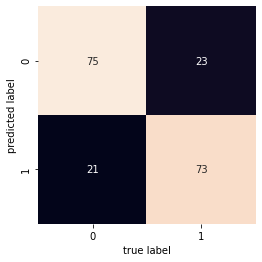

In [49]:
#cm=confusion_matrix(y_test,y_pred)
#cm
from sklearn.metrics import confusion_matrix
import seaborn as sns
#plt.figure(figsize=(10,7))
mat = confusion_matrix(y_test,y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');


In [50]:
from numpy import mean
from numpy import std
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pandas as pd
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import tree
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def cross_validation(clf,x,y,cv=5):     
    scoring={'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1_macro': make_scorer(f1_score, average = 'macro'),
           #'f1_weighted': make_scorer(f1_score, average = 'weighted')
        }    
    results = cross_validate(clf, x, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=True)

    return {"Training Accuracy scores": results['train_accuracy'],
             "Validation Accuracy scores": results['test_accuracy'], 
            
              "Training Precision scores": results['train_precision'],
              "Validation Precision scores": results['test_precision'],
          
              "Training Recall scores": results['train_recall'],
             "Validation Recall scores": results['test_recall'],
            
              "Training F1 scores": results['train_f1_macro'],
             "Validation F1 scores": results['test_f1_macro'],
            
             "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Mean Training Precision": results['train_precision'].mean(),
              "Mean Validation Precision": results['test_precision'].mean(),
              "Mean Training Recall": results['train_recall'].mean(),
              "Mean Validation Recall": results['test_recall'].mean(),
              "Mean Training F1 Score": results['train_f1_macro'].mean(),
              "Mean Validation F1 Score": results['test_f1_macro'].mean()
                      }



nb_result = cross_validation(clf, x_train,y_train, 5)
print(nb_result)

# report performance
#print('%.3f', 100*scores)
#print('Accuracy: %.3f (%.3f)' % (100*mean(scores['accuracy_score']), 100*std(scores['accuracy'])))

{'Training Accuracy scores': array([0.76086957, 0.74403471, 0.75488069, 0.76572668, 0.76355748]), 'Validation Accuracy scores': array([0.71551724, 0.74782609, 0.73043478, 0.73043478, 0.68695652]), 'Training Precision scores': array([0.7637413 , 0.74449264, 0.75662559, 0.76574499, 0.76500265]), 'Validation Precision scores': array([0.71609538, 0.74969568, 0.73049002, 0.73047821, 0.69047619]), 'Training Recall scores': array([0.76086957, 0.74398645, 0.75479014, 0.76573499, 0.76347638]), 'Validation Recall scores': array([0.71551724, 0.74818512, 0.73049002, 0.73033878, 0.68632789]), 'Training F1 scores': array([0.76021685, 0.74388889, 0.75441847, 0.76572558, 0.76319646]), 'Validation F1 scores': array([0.71532684, 0.74752063, 0.73043478, 0.73035323, 0.68502739]), 'Mean Training Accuracy': 75.78138262755823, 'Mean Validation Accuracy': 72.22338830584707, 'Mean Training Precision': 0.7591214368836503, 'Mean Validation Precision': 0.7234470951047806, 'Mean Training Recall': 0.757771503858460

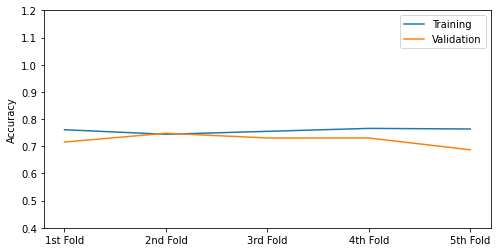

In [51]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold","6th Fold","7th Fold"]
X_axis = np.arange(len(labels))
plt.xticks(X_axis, labels)  
# Function to plot  
plt.ylim(0.40000, 1.2)
plt.plot(
nb_result["Training Accuracy scores"])
plt.plot(
nb_result["Validation Accuracy scores"])
plt.ylabel("Accuracy")  
# Function add a legend  
plt.legend(["Training", "Validation"], loc ="upper right")
  
# function to show the plot
plt.show()

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
x,y=load_data()
lda = LDA(n_components=1)
x = lda.fit_transform(x, y)
#x_test = lda.transform(x_test)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,stratify=y)
model = GaussianNB(var_smoothing= 0.1873817422860384)
model.fit(x_train,y_train)

GaussianNB(var_smoothing=0.1873817422860384)

In [55]:
y_true, y_pred = y_test , model.predict(x_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
               precision    recall  f1-score   support

    confident       0.86      0.78      0.82        96
not_confident       0.80      0.88      0.84        96

     accuracy                           0.83       192
    macro avg       0.83      0.83      0.83       192
 weighted avg       0.83      0.83      0.83       192

